In [737]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import math
ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client_throughput(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients_throughput(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))

async def run_multiple_clients_latency(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/latency_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_receivers(num_clients, hostname, device_id_prefix = "receiver", server="http://node0:8080",  startID = 0, asyncOn = True, slient = True):
    command_str = 'cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh {} {} {} {}'.format(num_clients, device_id_prefix,server, startID)
    if not silent:
        print(command_str)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
    
async def run_multiple_clients_group(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", receiver_prefix = "receiver", group_size = 1, independent = 1, startID=0, asyncOn = True, silent = True):
    command_str = 'cd /mydata/localuser/frida/experiments/groupsize_bench && bash ./run_clients_local.sh {} {} {} {} {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server, receiver_prefix, group_size, independent, startID)
    if not silent:
        print(command_str)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
    
    
async def clear_server_storage(hostname):
    await run_command_sync(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command_sync(hostname, "pkill server")
    

async def kill_clients(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "pkill client")
        await run_command_sync("node{}".format(i), "pkill groupclient")
        
async def remove_results(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "rm -r ~/exp_results")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])

async def kill_receivers(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "pkill receiver")

# Kill everything
async def cleanup(num_nodes):
    await kill_clients(num_nodes)
    await kill_receivers(num_nodes)
    await kill_server("node0")
    await clear_server_storage("node0")
    await remove_results(num_nodes)
    

def co_sort(arr1, arr2, on="first"):
    combined = [(arr1[i], arr2[i]) for i in range(len(arr1))]
    combined.sort(key=(lambda x:x[0]) if on=="first" else (lambda x:x[1]))
    return [e[0] for e in combined],[e[1] for e in combined]

def write_to_file(filename, data):
    with open(filename, "a") as f:
        if type(data) == str:
            f.write(data)
        elif type(data) == list:
            for e in data:
                f.write("{}\n".format(e))
def read_from_file(filename, dirname = "exp_data/"):
    data = []
    with open(dirname+filename) as f:
        for line in f:
            data.append(float(f))
    return data

In [723]:
await cleanup(10)
await run_server("node0")

In [367]:
def plot_by_buckets(raw_ts, raw_avgs, raw_p50s, raw_p90s, raw_p99s, show = "1000", bucket_size = 1000):
    throughputs_sorted, avgs_sorted = co_sort(raw_ts, raw_avgs)
    throughputs_sorted, p50s_sorted = co_sort(raw_ts, raw_p50s)
    throughputs_sorted, p90s_sorted = co_sort(raw_ts, raw_p90s)
    throughputs_sorted, p99s_sorted = co_sort(raw_ts, raw_p99s)

    throughputs = throughputs_sorted
    avgs = avgs_sorted
    p50s = p50s_sorted
    p90s = p90s_sorted
    p99s = p99s_sorted

    buckets = dict()
    for i, val in enumerate(throughputs):
        bucket = int(val // bucket_size)
        if bucket not in buckets:
            buckets[bucket] = []
        buckets[bucket].append((throughputs[i], avgs[i], p50s[i], p90s[i], p99s[i]))

    better_ts = []
    better_avgs = []
    better_p50s = []
    better_p90s = []
    better_p99s = []
    for k,v in buckets.items():
        sum_ts = 0
        sum_avgs = 0
        sum_p50s = 0
        sum_p90s = 0
        sum_p99s = 0
        for e in v:
            sum_ts += e[0]
            sum_avgs += e[1]
            sum_p50s += e[2]
            sum_p90s += e[3]
            sum_p99s += e[4]
        better_ts.append(sum_ts/len(v))
        better_avgs.append(sum_avgs/len(v))
        better_p50s.append(sum_p50s/len(v))
        better_p90s.append(sum_p90s/len(v))
        better_p99s.append(sum_p99s/len(v))
    if show[0] == "1":
        plt.plot(np.array(better_ts)/1000.0, better_avgs, label="Average")
    if show[1] == "1":
        plt.plot(np.array(better_ts)/1000.0, better_p50s, label="p50s")
    if show[2] == "1":
        plt.plot(np.array(better_ts)/1000.0, better_p90s, label="p90s")
    if show[3] == "1":
        plt.plot(np.array(better_ts)/1000.0, better_p99s, label="p99s")
    plt.xticks(np.arange(0, 22, step = 2))
    plt.xlabel("Throughput (1K req/s)")
    plt.ylabel("Latency (ms)")
    plt.legend()
    plt.show()

In [383]:
async def run_throughput_exp(num_nodes = 2, duration = 20, keepout = 5, data_size = 0, min_cpn = 20, max_cpn = 100, step_size = 5, warmup_period = 5, server_node = "node0"):
    max_clients = max_cpn * num_nodes
    throughputs = [0]
    num_clients_record = [0]
    

    for num_clients_per_node in range(min_cpn, max_cpn + 1, step_size):
        await cleanup(num_nodes)
        time.sleep(10)
        server_task = await run_server(server_node)
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_throughput(num_clients_per_node, "node{}".format(node), "exp_throughput_C{}_node{}_{}".format(num_clients, node, randrange(1000000)), duration, keepout, data_size, "http://node0:8080")
            ctasks.append(ctask)
        local_throughputs = []
        time.sleep(duration + warmup_period)
        
        curr_node = 0
        for ctask in ctasks:
            curr_node += 1
            coutput = await ctask.stdout.read()
            cerror = await ctask.stderr.read()
            if str(cerror) != "":
                print("Node {}: ".format(curr_node) + str(cerror))
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    local_throughputs.append(parse_throughput(line))
            ctask.terminate()
        num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        print("#Nodes={}, #Clients={}, Throughput = {:.2f}/s".format(num_nodes, num_clients, throughput))
        throughputs.append(throughput)

    server_task.terminate()
#     await clear_server_storage(server_node)
    return num_clients_record, throughputs

In [712]:
ctasks =[]
for i in range(1,2):
    ctask = await run_multiple_clients_group(100, "node{}".format(i), "ex{:06d}".format(randrange(1000000)), 16, 3, 0, "http://node0:8080", "rec", 5, 1, startID = 0, asyncOn=True)
    ctasks.append(ctask)
sumt = 0
# time.sleep(30)
for ctask in ctasks:
    output = (await ctask.stdout.read())
    for line in output.split("\n")[:-1]:
        if line != "":
            sumt+=float(line)
print(sumt/10.0)

12382.6


In [721]:
async def run_groupsize_exp_single(num_nodes = 10, duration = 20, keepout = 5, data_size = 0,num_clients = 100, server_node = "node0",receiver_prefix="r", group_size = 1, independent = 1, trial = 0):
    time.sleep(5)
    ctasks = []
    
    for node in range(1, num_nodes + 1):
        num_clients_this_node = (num_clients // num_nodes + (1 if (node-1) < (num_clients % num_nodes) else 0))
        ctask = await run_multiple_clients_group(num_clients, "node{}".format(node), "G{:03d}_N{:02d}_{:06d}".format(group_size, node, randrange(1000000)), duration, keepout, data_size, "http://node0:8080", receiver_prefix, group_size, independent, startID = 0, asyncOn=True)
        ctasks.append(ctask)
        
    time.sleep(duration)
    nmsgs = []
    curr_node = 0
    for ctask in ctasks:
        curr_node += 1
        coutput = await ctask.stdout.read()
        cerror = await ctask.stderr.read()
        if str(cerror) != "":
            print("Node {}: \n".format(curr_node) + str(cerror))
        for line in coutput.split("\n")[:-1]:
            if line != "":
                nmsg = float(line)
                nmsgs.append(nmsg)
        ctask.terminate()
    throughput = float(sum(nmsgs) / (duration - 2* keepout))
    return throughput

In [735]:
group_sizes = list(range(1,21))
# group_sizes = [5]*10
num_clients = 10
num_sender_nodes = 1
num_receiver_nodes = 5

warmup_runs = 2
# print("Clearing up server and clients...")
# await cleanup(num_nodes)
# time.sleep(5)
# server_task = await run_server(server_node)
# time.sleep(5)
# print("{} warm-ups running...".format(warmup_runs))
# for i in range(warmup_runs):
#     await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)

# print("Starting receivers...")
# startID = 0
# for node in range(num_receiver_nodes):
#     num_receivers_this_node = (num_receivers // num_receiver_nodes + (1 if node < (num_receivers % num_receiver_nodes) else 0))
#     await run_multiple_receivers(num_receivers_this_node,  "node{}".format(node+num_sender_nodes), "C{}_receiver".format(num_clients), startID = startID)
#     startID += num_receivers_this_node
# time.sleep(10)

print("Starting groupsize bench...")
throughputs = []
for size in group_sizes:
    print("Clearing up server and clients...")
    await cleanup(num_nodes)
    time.sleep(3)
    server_task = await run_server(server_node)
    time.sleep(3)
#     print("{} warm-ups running...".format(warmup_runs))
#     for i in range(warmup_runs):
#         await run_latency_exp_single(num_nodes, 10, 1, num_clients = 100, server_node=server_node, is_warmup=True)
    throughput = await run_groupsize_exp_single(duration = 14, keepout = 2, num_nodes = num_sender_nodes, num_clients = num_clients, receiver_prefix = "rec", group_size = size)
    print("#N={}, #C={}, G = {}, T = {:.2f}".format(num_sender_nodes, num_clients, size, throughput))
    throughputs.append(throughput)

Starting groupsize bench...
Clearing up server and clients...
#N=1, #C=10, G = 1, T = 753.00
Clearing up server and clients...
#N=1, #C=10, G = 2, T = 779.50
Clearing up server and clients...
#N=1, #C=10, G = 3, T = 734.40
Clearing up server and clients...
#N=1, #C=10, G = 4, T = 754.70
Clearing up server and clients...
#N=1, #C=10, G = 5, T = 736.70
Clearing up server and clients...
#N=1, #C=10, G = 6, T = 778.40
Clearing up server and clients...
#N=1, #C=10, G = 7, T = 770.80
Clearing up server and clients...
#N=1, #C=10, G = 8, T = 754.30
Clearing up server and clients...
#N=1, #C=10, G = 9, T = 738.10
Clearing up server and clients...
#N=1, #C=10, G = 10, T = 778.90
Clearing up server and clients...
#N=1, #C=10, G = 11, T = 765.50
Clearing up server and clients...
#N=1, #C=10, G = 12, T = 741.30
Clearing up server and clients...
#N=1, #C=10, G = 13, T = 731.90
Clearing up server and clients...
#N=1, #C=10, G = 14, T = 779.40
Clearing up server and clients...
#N=1, #C=10, G = 15, T 

In [730]:
throughputs_C10 = throughputs
group_sizes_C10 = group_sizes
%store throughputs_C10
%store group_sizes_C10
write_to_file("throughputs_C10", throughputs_C10)
write_to_file("group_sizes_C10", group_sizes_C10)

Stored 'throughputs_C10' (list)
Stored 'group_sizes_C10' (list)


In [ ]:
plt.plot(group_sizes_shortname, throughputs_shortname, label="4 Nodes")
plt.xticks(np.arange(0, 21, step = 1))
plt.xlabel("Group Size")
plt.ylabel("Throughput")
plt.legend()
plt.show()

In [ ]:
throughputs_C40_G20_Roff = throughputs
group_sizes_C40_G20_Roff = group_sizes
%store throughputs_C40_G20_Roff
%store group_sizes_C40_G20_Roff
write_to_file("throughputs_C40_G20_Roff", throughputs_C40_G20_Roff)
write_to_file("group_sizes_C40_G20_Roff", group_sizes_C40_G20_Roff)

In [531]:
throughputs_C100_G20_Roff_BUCKET1M = throughputs
group_sizes_C100_G20_Roff_BUCKET1M = group_sizes
%store throughputs_C100_G20_Roff_BUCKET1M
%store group_sizes_C100_G20_Roff_BUCKET1M
write_to_file("throughputs_C100_G20_Roff_BUCKET1M", throughputs_C100_G20_Roff_BUCKET1M)
write_to_file("group_sizes_C100_G20_Roff_BUCKET1M", group_sizes_C100_G20_Roff_BUCKET1M)

Stored 'throughputs_C100_G20_Roff_BUCKET1M' (list)
Stored 'group_sizes_C100_G20_Roff_BUCKET1M' (list)


In [450]:
throughputs_C100_G20_Roff = throughputs
group_sizes_C100_G20_Roff = group_sizes
%store throughputs_C100_G20_Roff
%store group_sizes_C100_G20_Roff
write_to_file("throughputs_C100_G20_Roff", throughputs_C100_G20_Roff)
write_to_file("group_sizes_C100_G20_Roff", group_sizes_C100_G20_Roff)

Stored 'throughputs_C100_G20_Roff' (list)
Stored 'group_sizes_C100_G20_Roff' (list)


In [445]:
throughputs_C100_G20 = throughputs
group_sizes_C100_G20 = group_sizes
%store throughputs_C100_G20
%store group_sizes_C100_G20
write_to_file("throughputs_C100_G20", throughputs_C100_G20)
write_to_file("group_sizes_C100_G20", group_sizes_C100_G20)

Stored 'throughputs_C100_G20' (list)
Stored 'group_sizes_C100_G20' (list)


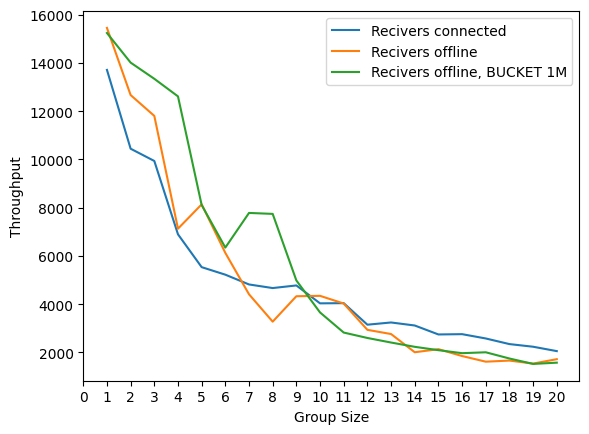

In [533]:
plt.plot(group_sizes_C100_G20, throughputs_C100_G20, label="Recivers connected")
plt.plot(group_sizes_C100_G20_Roff, throughputs_C100_G20_Roff, label="Recivers offline")
plt.plot(group_sizes_C100_G20_Roff_BUCKET1M, throughputs_C100_G20_Roff_BUCKET1M, label="Recivers offline, BUCKET 1M")
plt.xticks(np.arange(0, 21, step = 1))
plt.xlabel("Group Size")
plt.ylabel("Throughput")
plt.legend()
plt.show()

In [482]:
async def run_conflicts_exp_single(num_nodes = 10, duration = 20, keepout = 5, data_size = 0,num_clients = 100, server_node = "node0", conflict_prefix = "conflict", receiver_prefix="receiver", num_rand = 1,trial = 0):
    time.sleep(5)
    ctasks = []
    
    startID = 0
    
    for node in range(1, num_nodes + 1):
        num_clients_this_node = (num_clients // num_nodes + (1 if node < (num_clients % num_nodes) else 0))
        ctask = await run_multiple_clients_group(num_clients_this_node, "node{}".format(node),conflict_prefix, duration, keepout, data_size, "http://node0:8080",receiver_prefix, 0, num_clients,num_rand, startID)
        startID += num_clients_this_node
        ctasks.append(ctask)
        
    time.sleep(duration)
    nmsgs = []
    curr_node = 0
    for ctask in ctasks:
        curr_node += 1
        coutput = await ctask.stdout.read()
        cerror = await ctask.stderr.read()
        if str(cerror) != "":
            print("Node {}: \n".format(curr_node) + str(cerror))
        for line in coutput.split("\n")[:-1]:
            if line != "":
                nmsg = float(line)
                nmsgs.append(nmsg)
        ctask.terminate()
    throughput = float(sum(nmsgs) / (duration - 2* keepout))
    return throughput

In [492]:
num_clients = 100
group_sizes = list(range(1,21))
num_sender_nodes = 4
num_receiver_nodes = 5
num_receivers = 100
warmup_runs = 3
print("Clearing up server and clients...")
await cleanup(num_nodes)
time.sleep(5)
server_task = await run_server(server_node)
time.sleep(5)
print("{} warm-ups running...".format(warmup_runs))
for i in range(warmup_runs):
    await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)
print("Starting receivers...")

receiver_prefix =  "C{}_receiver".format(num_clients)
startID = 0
for node in range(num_receiver_nodes):
    num_receivers_this_node = (num_receivers // num_receiver_nodes + (1 if node < (num_receivers % num_receiver_nodes) else 0))
    await run_multiple_receivers(num_receivers_this_node,  "node{}".format(node+num_sender_nodes), receiver_prefix, startID = startID)
    startID += num_receivers_this_node

time.sleep(10)
print("Starting conflict bench...")
throughputs = []
for size in group_sizes:
    conflict_prefix = "exp_conflicts_C{}_G{}_trial{}_{}".format(num_clients,size, 0, randrange(1000000))
    throughput = await run_conflicts_exp_single(num_nodes = num_sender_nodes, num_clients = num_clients, conflict_prefix = conflict_prefix, receiver_prefix =  receiver_prefix, num_rand = size - 1)
    print("#N={}, #C={}, G = {}, T = {}".format(num_sender_nodes, num_clients, size, throughput))
    throughputs.append(throughput)

Clearing up server and clients...
3 warm-ups running...
Starting receivers...
cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh 20 C100_receiver http://node0:8080 0
cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh 20 C100_receiver http://node0:8080 20
cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh 20 C100_receiver http://node0:8080 40
cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh 20 C100_receiver http://node0:8080 60
cd /mydata/localuser/frida/experiments/receiver && bash ./run_clients_local.sh 20 C100_receiver http://node0:8080 80
Starting conflict bench...
#N=4, #C=100, G = 1, T = 15154.5
#N=4, #C=100, G = 2, T = 10470.6
#N=4, #C=100, G = 3, T = 4766.5
#N=4, #C=100, G = 4, T = 1765.9
#N=4, #C=100, G = 5, T = 1218.7
#N=4, #C=100, G = 6, T = 771.7
#N=4, #C=100, G = 7, T = 744.5
#N=4, #C=100, G = 8, T = 613.8
#N=4, #C=100, G = 9, T = 558.3
#N=4, #C=100, G = 10, T =

In [494]:
throughputs_conflict_C100_G20_NORECV = throughputs
group_sizes_conflict_C100_G20_NORECV = group_sizes
%store throughputs_conflict_C100_G20_NORECV
%store group_sizes_conflict_C100_G20_NORECV
write_to_file("throughputs_conflict_C100_G20_NORECV", throughputs_conflict_C100_G20_NORECV)
write_to_file("group_sizes_conflict_C100_G20_NORECV", group_sizes_conflict_C100_G20_NORECV)

Stored 'throughputs_conflict_C100_G20_NORECV' (list)
Stored 'group_sizes_conflict_C100_G20_NORECV' (list)


In [486]:
num_clients = 100
group_sizes = list(range(1,11))
num_sender_nodes = 4
# num_receiver_nodes = 5
# num_receivers = max(group_sizes) * num_clients
warmup_runs = 3
print("Clearing up server and clients...")
await cleanup(num_nodes)
time.sleep(5)
server_task = await run_server(server_node)
time.sleep(5)
print("{} warm-ups running...".format(warmup_runs))
for i in range(warmup_runs):
    await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)
# print("Starting receivers...")
# startID = 0
# for node in range(num_receiver_nodes):
#     num_receivers_this_node = (num_receivers // num_receiver_nodes + (1 if node < (num_receivers % num_receiver_nodes) else 0))
#     await run_multiple_receivers(num_receivers_this_node,  "node{}".format(node+num_sender_nodes), "C{}_receiver".format(num_clients), startID = startID)
#     startID += num_receivers_this_node

time.sleep(10)
print("Starting conflict bench...")
throughputs = []
for size in group_sizes:
    conflict_prefix = "exp_conflicts_C{}_G{}_trial{}_{}".format(num_clients,size, 0, randrange(1000000))
    throughput = await run_conflicts_exp_single(num_nodes = num_sender_nodes, num_clients = num_clients, conflict_prefix = conflict_prefix, receiver_prefix = conflict_prefix, num_rand = size - 1)
    print("#N={}, #C={}, G = {}, T = {}".format(num_sender_nodes, num_clients, size, throughput))
    throughputs.append(throughput)

Clearing up server and clients...
3 warm-ups running...
Starting conflict bench...
#N=4, #C=100, G = 1, T = 15428.2
#N=4, #C=100, G = 2, T = 4600.1
#N=4, #C=100, G = 3, T = 2387.5
#N=4, #C=100, G = 4, T = 1263.3
#N=4, #C=100, G = 5, T = 769.8
#N=4, #C=100, G = 6, T = 630.3
#N=4, #C=100, G = 7, T = 583.9
#N=4, #C=100, G = 8, T = 577.9
#N=4, #C=100, G = 9, T = 510.1
#N=4, #C=100, G = 10, T = 558.9


In [487]:
throughputs_conflict_C100_G10 = throughputs
group_sizes_conflict_C100_G10 = group_sizes
%store throughputs_conflict_C100_G10
%store group_sizes_conflict_C100_G10
write_to_file("throughputs_conflict_C100_G10", throughputs_conflict_C100_G10)
write_to_file("group_sizes_conflict_C100_G10", group_sizes_conflict_C100_G10)

Stored 'throughputs_conflict_C100_G10' (list)
Stored 'group_sizes_conflict_C100_G10' (list)


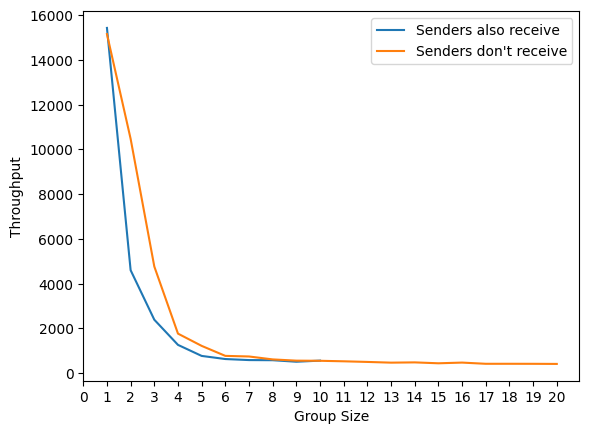

In [497]:
plt.plot(group_sizes_conflict_C100_G10, throughputs_conflict_C100_G10, label="Senders also receive")
plt.plot(group_sizes_conflict_C100_G20_NORECV, throughputs_conflict_C100_G20_NORECV, label="Senders don't receive")
plt.xticks(np.arange(0, 21, step = 1))
plt.xlabel("Group Size")
plt.ylabel("Throughput")
plt.legend()
plt.show()

In [715]:
async def run_latency_exp_single(num_nodes = 10, duration = 20, keepout = 5, data_size = 0,num_clients = 100, server_node = "node0", is_warmup = False, trial = 0):
#     num_clients = num_nodes * num_clients_per_node
    time.sleep(5)
    ctasks = []
    
    for node in range(1, num_nodes + 1):
        num_clients_this_node = (num_clients // num_nodes + (1 if node < (num_clients % num_nodes) else 0))
        ctask = await run_multiple_clients_latency(num_clients_this_node, "node{}".format(node), "C{:03d}_N{:02d}_{:06d}".format(num_clients, node, randrange(1000000)), duration, keepout, data_size, "http://node0:8080")
        ctasks.append(ctask)
        
    time.sleep(duration)
    curr_node = 0
    
    all_latencies = []
    for ctask in ctasks:
        curr_node += 1
        coutput = await ctask.stdout.read()
        cerror = await ctask.stderr.read()
        if str(cerror) != "":
            print("Node {}: \n".format(curr_node) + str(cerror))
        if not is_warmup:
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    lat = float(line)
                    all_latencies.append(lat)
        ctask.terminate()
    if not is_warmup:
        nmesg = len(all_latencies)
        throughput = float(nmesg) / (duration - 2* keepout)
        average_lat = sum(all_latencies) / nmesg / 1000.0

        all_latencies.sort()
        p50_lat = all_latencies[nmesg // 2] / 1000.0
        p90_lat = all_latencies[int(nmesg * 0.9)] / 1000.0
        p99_lat = all_latencies[int(nmesg * 0.99)] / 1000.0
        return throughput, average_lat, p50_lat, p90_lat, p99_lat
    else:
        return None, None, None, None, None
    
#     print("#N={}, #C={}, Throughput = {}, Avg = {}ms, 50th = {}ms, 90th = {}, 99th = {}".format(num_nodes, num_clients, throughput, average_lat, p50_lat, p90_lat, p99_lat))

In [509]:
fine_list = []
curr = 1000
step = 1000
for i, val in enumerate(throughputs_n4_fine_final):
    if(val > curr):
        num_prev = num_clients_n4_fine_final[i-1]
        num_this = num_clients_n4_fine_final[i]
        val_prev = throughputs_n4_fine_final[i-1]
#         print(num_prev,num_this, val, curr)
        num_interpolate = int(num_prev + (curr - val_prev) / (val - val_prev) * (num_this - num_prev))
        if num_interpolate < 0:
            num_interpolate = -num_interpolate
        fine_list.append(num_interpolate)
#         print(val)
        curr+=step
print(fine_list)

[12, 22, 27, 32, 36, 41, 45, 50, 60, 58, 75, 78, 90, 95, 108, 116, 135, 163, 195, 297]


In [511]:
num_list = list(range(2,50,2)) + list(range(50, 300, 5))
print(num_list)
num_nodes = 4
duration = 16
keepout = 3
data_size = 0
warmup_runs = 3
repeat = 1
server_node = "node0"

throughputs = []
avgs = []
p50s = []
p90s = []
p99s = []
print("Clearing up server and clients...")
await cleanup(num_nodes)
time.sleep(5)
server_task = await run_server(server_node)
time.sleep(5)
print("{} warm-ups running...".format(warmup_runs))
for i in range(warmup_runs):
    await run_latency_exp_single(num_nodes, 20, 1, num_clients = 200, server_node=server_node, is_warmup=True)
print("Starting benchmark...")
for num_clients in num_list:
    sample_throughputs = []
    sample_avgs = []
    sample_p50s = []
    sample_p90s = []
    sample_p99s = []
    for trial in range(repeat):
        throughput, avg, p50, p90, p99 = await run_latency_exp_single(num_nodes, duration, keepout, data_size, num_clients, server_node, trial = trial)
        sample_throughputs.append(throughput)
        sample_avgs.append(avg)
        sample_p50s.append(p50)
        sample_p90s.append(p90)
        sample_p99s.append(p99)
    print("#N={}, #C={},T = {}, Avgs = {}".format(num_nodes, num_clients, sample_throughputs, sample_avgs))
    mean_throughput = sum(sample_throughputs) / repeat
    mean_avg = sum(sample_avgs) / repeat
    mean_p50 = sum(sample_p50s) / repeat
    mean_p90 = sum(sample_p90s) / repeat
    mean_p99 = sum(sample_p99s) / repeat
        
    print("#N={}, #C={}, Throughput = {:.2f}, Avg = {:.2f}ms, 50th = {:.2f}ms, 90th = {:.2f}ms, 99th = {:.2f}ms".format(num_nodes, num_clients, mean_throughput, mean_avg, mean_p50, mean_p90, mean_p99))
    throughputs.append(mean_throughput)
    avgs.append(mean_avg)
    p50s.append(mean_p50)
    p90s.append(mean_p90)
    p99s.append(mean_p99)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295]
Clearing up server and clients...
3 warm-ups running...
Starting benchmark...
#N=4, #C=2,T = [378.4], Avgs = [2.6049460887949256]
#N=4, #C=2, Throughput = 378.40, Avg = 2.60ms, 50th = 2.12ms, 90th = 3.44ms, 99th = 3.49ms
#N=4, #C=4,T = [934.5], Avgs = [5.9240067415730335]
#N=4, #C=4, Throughput = 934.50, Avg = 5.92ms, 50th = 5.40ms, 90th = 8.48ms, 99th = 8.66ms
#N=4, #C=6,T = [1147.2], Avgs = [6.339555090655509]
#N=4, #C=6, Throughput = 1147.20, Avg = 6.34ms, 50th = 5.48ms, 90th = 8.50ms, 99th = 12.49ms
#N=4, #C=8,T = [1824.0], Avgs = [6.897311184210526]
#N=4, #C=8, Throughput = 1824.00, Avg = 6.90ms, 50th = 8.36ms, 90th = 8.54ms, 99th = 12.00ms
#N=4, #C=10,T

In [513]:
throughputs_N4_C2to300 = throughputs
avgs_N4_C2to300=avgs
p50s_N4_C2to300=p50s
p90s_N4_C2to300=p90s
p99s_N4_C2to300=p99s
    
%store throughputs_N4_C2to300
%store avgs_N4_C2to300
%store p50s_N4_C2to300
%store p90s_N4_C2to300
%store p99s_N4_C2to300

write_to_file("throughputs_N4_C2to300", throughputs_N4_C2to300)
write_to_file("avgs_N4_C2to300", avgs_N4_C2to300)
write_to_file("p50s_N4_C2to300", p50s_N4_C2to300)
write_to_file("p90s_N4_C2to300", p90s_N4_C2to300)
write_to_file("p99s_N4_C2to300", p99s_N4_C2to300)

Stored 'throughputs_N4_C2to300' (list)
Stored 'avgs_N4_C2to300' (list)
Stored 'p50s_N4_C2to300' (list)
Stored 'p90s_N4_C2to300' (list)
Stored 'p99s_N4_C2to300' (list)


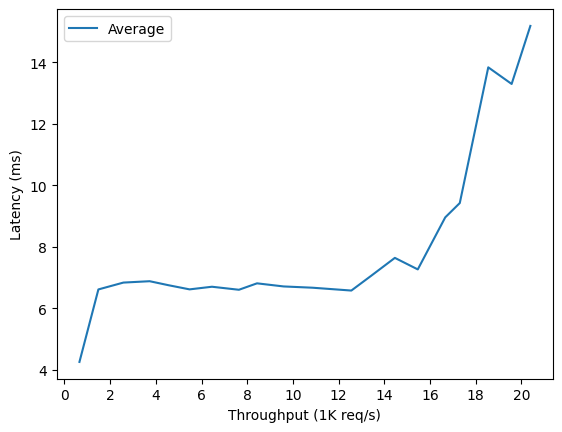

In [543]:
plot_by_buckets(throughputs_N4_C2to300, avgs_N4_C2to300, p50s_N4_C2to300, p90s_N4_C2to300, p99s_N4_C2to300, show="1000", bucket_size = 1000)

In [340]:
throughputs_logscale = throughputs
avgs_logscale = avgs
p50s_logscale=p50s
p90s_logscale=p90s
p99s_logscale=p99s
    
%store throughputs_logscale
%store avgs_logscale
%store p50s_logscale
%store p90s_logscale
%store p99s_logscale

write_to_file("throughputs_logscale", throughputs_logscale)
write_to_file("avgs_logscale", avgs_logscale)
write_to_file("p50s_logscale", p50s_logscale)
write_to_file("p90s_logscale", p90s_logscale)
write_to_file("p99s_logscale", p99s_logscale)

Stored 'throughputs_logscale' (list)
Stored 'avgs_logscale' (list)
Stored 'p50s_logscale' (list)
Stored 'p90s_logscale' (list)
Stored 'p99s_logscale' (list)


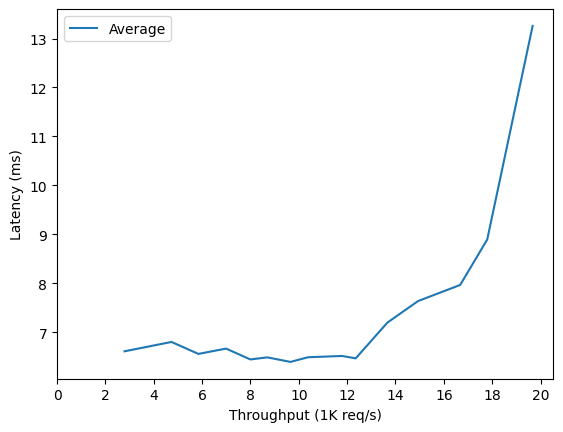

In [464]:
plot_by_buckets(throughputs_logscale, avgs_logscale, p50s_logscale, p90s_logscale, p99s_logscale, show="1000", bucket_size=1000)

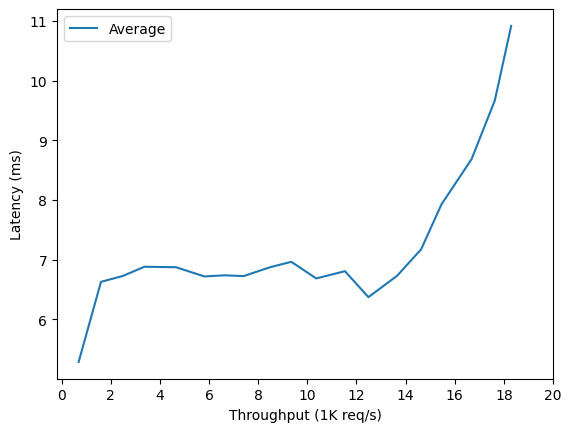

In [370]:
plot_by_buckets(throughputs_finer, avgs_finer, p50s_finer, p90s_finer, p99s_finer, show="1000")

In [207]:
throughputs_real = throughputs
avgs_real = avgs
p50s_real=p50s
p90s_real=p90s
p99s_real=p99s
    
%store throughputs_real
%store avgs_real
%store p50s_real
%store p90s_real
%store p99s_real

Stored 'throughputs_real' (list)
Stored 'avgs_real' (list)
Stored 'p50s_real' (list)
Stored 'p90s_real' (list)
Stored 'p99s_real' (list)


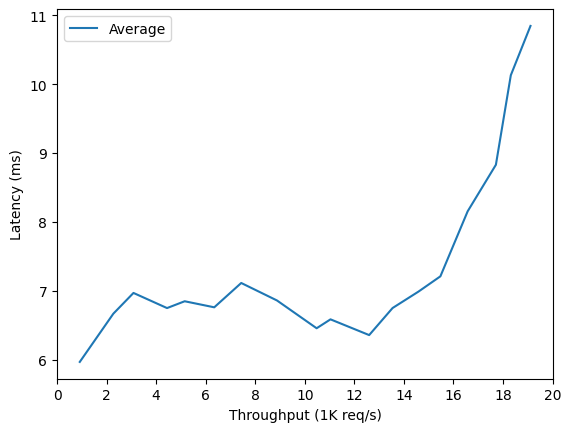

In [373]:
plot_by_buckets(throughputs_real, avgs_real, p50s_real, p90s_real, p99s_real, show="1000")

In [241]:
write_to_file("throughputs_real", throughputs_real)
write_to_file("avgs_real", avgs_real)
write_to_file("p50s_real", p50s_real)
write_to_file("p90s_real", p90s_real)
write_to_file("p99s_real", p99s_real)

In [151]:
throughputs_test, avgs_test, p50s_test, p90s_test, p99s_test = await run_latency_exp(num_nodes = 10, duration = 30, keepout = 5, repeat=3, num_list=list(range(3,31,3)))
%store throughputs_test
%store avgs_test
%store p50s_test
%store p90s_test
%store p99s_test

Clearing up server and clients...
3 warm-ups running...
Starting benchmark...
#N=10, #C=30,T = [6553.2, 6555.85, 6636.45], Avgs = [6.656949902337789, 6.533140546229704, 6.499770148196702]
#N=10, #C=30, Throughput = 6581.833333333333, Avg = 6.563286865588065ms, 50th = 5.660666666666667ms, 90th = 8.620666666666667, 99th = 17.375333333333334
#N=10, #C=60,T = [12230.3, 11998.35, 11965.35], Avgs = [6.332923346115795, 6.439828359732797, 6.457574471285838]
#N=10, #C=60, Throughput = 12064.666666666666, Avg = 6.410108725711477ms, 50th = 5.324666666666666ms, 90th = 8.955, 99th = 21.798333333333332
#N=10, #C=90,T = [14807.0, 14554.6, 14481.15], Avgs = [7.244521648544607, 7.367480129993267, 7.389174792747814]
#N=10, #C=90, Throughput = 14614.25, Avg = 7.3337255237618955ms, 50th = 5.783333333333334ms, 90th = 11.835999999999999, 99th = 24.44633333333333
#N=10, #C=120,T = [17881.3, 17987.0, 17249.5], Avgs = [7.843479098275853, 7.8277245371657305, 8.140241951940636]
#N=10, #C=120, Throughput = 17705.

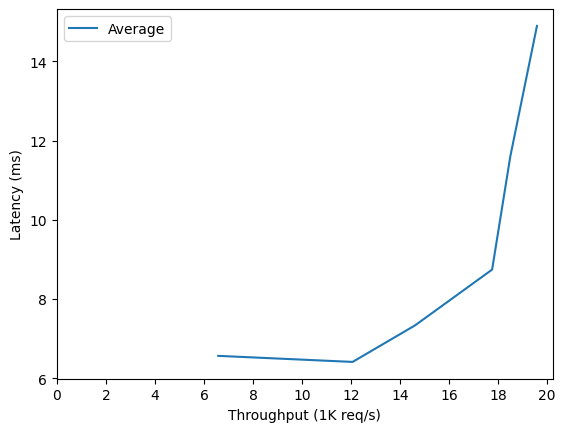

In [374]:
plot_by_buckets(throughputs_test, avgs_test, p50s_test, p90s_test, p99s_test, show="1000")

In [ ]:
throughputs_N10C20_nagle, latencies_N10C20_nagle = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 10, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20_nagle
%store latencies_N10C20_nagle

In [ ]:
throughputs_N10C20, latencies_N10C20 = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 20, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20
%store latencies_N10C20

In [ ]:
throughputs_N4C50, latencies_N4C50 = await run_latency_exp(num_nodes=4, duration = 70, keepout = 5, num_clients_per_node=50, min_tpc = 50, max_tpc = 120, step_size = 1,warmup_period = 5)
%store throughputs_N4C50
%store latencies_N4C50

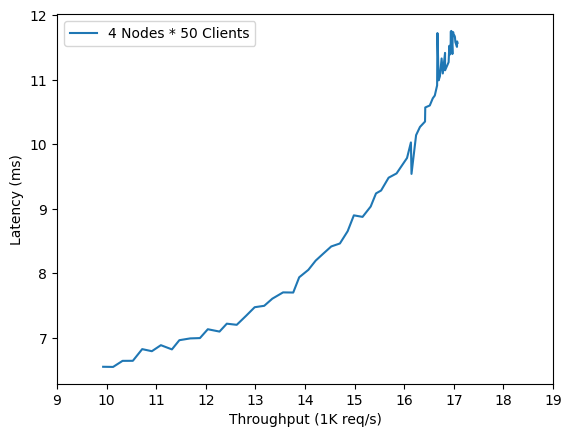

In [33]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N4C50, latencies_N4C50)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="4 Nodes * 50 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(9, 20, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [240]:
write_to_file("throughputs_N4C50", throughputs_N4C50)
write_to_file("latencies_N4C50", latencies_N4C50)

In [ ]:
num_clients_n1, throughputs_n1 = await run_throughput_exp(num_nodes = 1, min_cpn = 8, max_cpn = 200, step_size=8)
%store num_clients_n1
%store throughputs_n1

num_clients_n2, throughputs_n2 = await run_throughput_exp(num_nodes = 2, min_cpn = 4, max_cpn = 100, step_size=4)
%store num_clients_n2
%store throughputs_n2

num_clients_n4, throughputs_n4 = await run_throughput_exp(num_nodes = 4, min_cpn = 2, max_cpn = 50, step_size=2)
%store num_clients_n4
%store throughputs_n4

num_clients_n8, throughputs_n8 = await run_throughput_exp(num_nodes = 8, min_cpn = 1, max_cpn = 25, step_size=1)
%store num_clients_n8
%store throughputs_n8

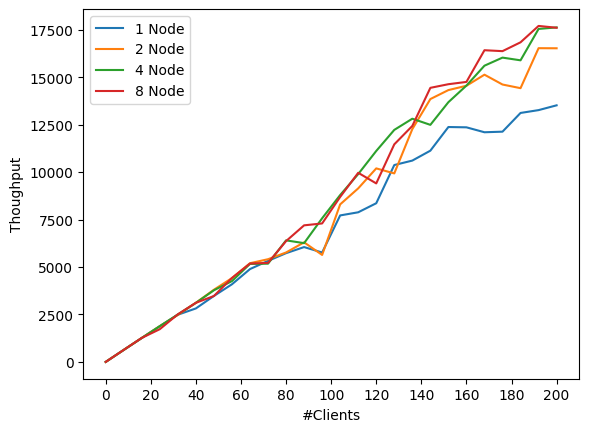

In [31]:
plt.plot(num_clients_n1, throughputs_n1, label="1 Node")
plt.plot(num_clients_n2, throughputs_n2, label="2 Node")
plt.plot(num_clients_n4, throughputs_n4, label="4 Node")
plt.plot(num_clients_n8, throughputs_n8, label="8 Node")
plt.xticks(np.arange(0, 201, step = 20))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [239]:
write_to_file("num_clients_n1", num_clients_n1)
write_to_file("throughputs_n1", throughputs_n1)
write_to_file("num_clients_n2", num_clients_n2)
write_to_file("throughputs_n2", throughputs_n2)
write_to_file("num_clients_n4", num_clients_n4)
write_to_file("throughputs_n4", throughputs_n4)
write_to_file("num_clients_n8", num_clients_n8)
write_to_file("throughputs_n8", throughputs_n8)

In [ ]:
num_clients_n4_fine, throughputs_n4_fine = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 2, max_cpn = 75, step_size=1)
%store num_clients_n4_fine
%store throughputs_n4_fine

In [ ]:
num_clients_n4_fine_more, throughputs_n4_fine_more = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 76, max_cpn = 100, step_size=1)
%store num_clients_n4_fine_more
%store throughputs_n4_fine_more

In [ ]:
num_clients_n4_fine_final = num_clients_n4_fine + num_clients_n4_fine_more[1:]
throughputs_n4_fine_final = throughputs_n4_fine + throughputs_n4_fine_more[1:]
%store num_clients_n4_fine_final
%store throughputs_n4_fine_final

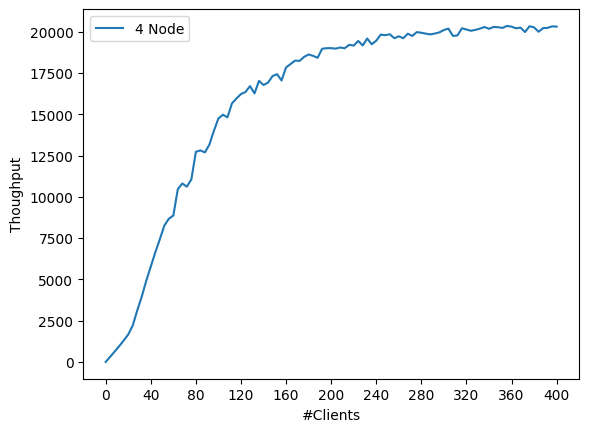

In [30]:
plt.plot(num_clients_n4_fine_final, throughputs_n4_fine_final, label="4 Node")
plt.xticks(np.arange(0, 401, step = 40))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [238]:
write_to_file("num_clients_n4_fine_final", num_clients_n4_fine_final)
write_to_file("throughputs_n4_fine_final", throughputs_n4_fine_final)